In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
import tensorflow as tf
import transformers
from transformers import TFBertForTokenClassification
from tqdm.notebook import tqdm

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import ABSATokenizer, convert_examples_to_tf_dataset, read_conll
import utils.utils as utils
import utils.pos_utils as pos_utils
import utils.postprocessing_utils as post_utils

## A. PoS

### A.1. Lang vs Group Accuracy

In [89]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)

In [90]:
df = results["Accuracy"]["langvgroup"].iloc[:4]
df = df.drop([np.nan, "Thai", "Baseline"], axis=1)
df = df.set_index("Test\Train").T.applymap(lambda x: x*100).reset_index()
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Train Language", 
                                                                                   "Test\Train": "Test Group",
                                                                                   "value": "Accuracy"})

In [91]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

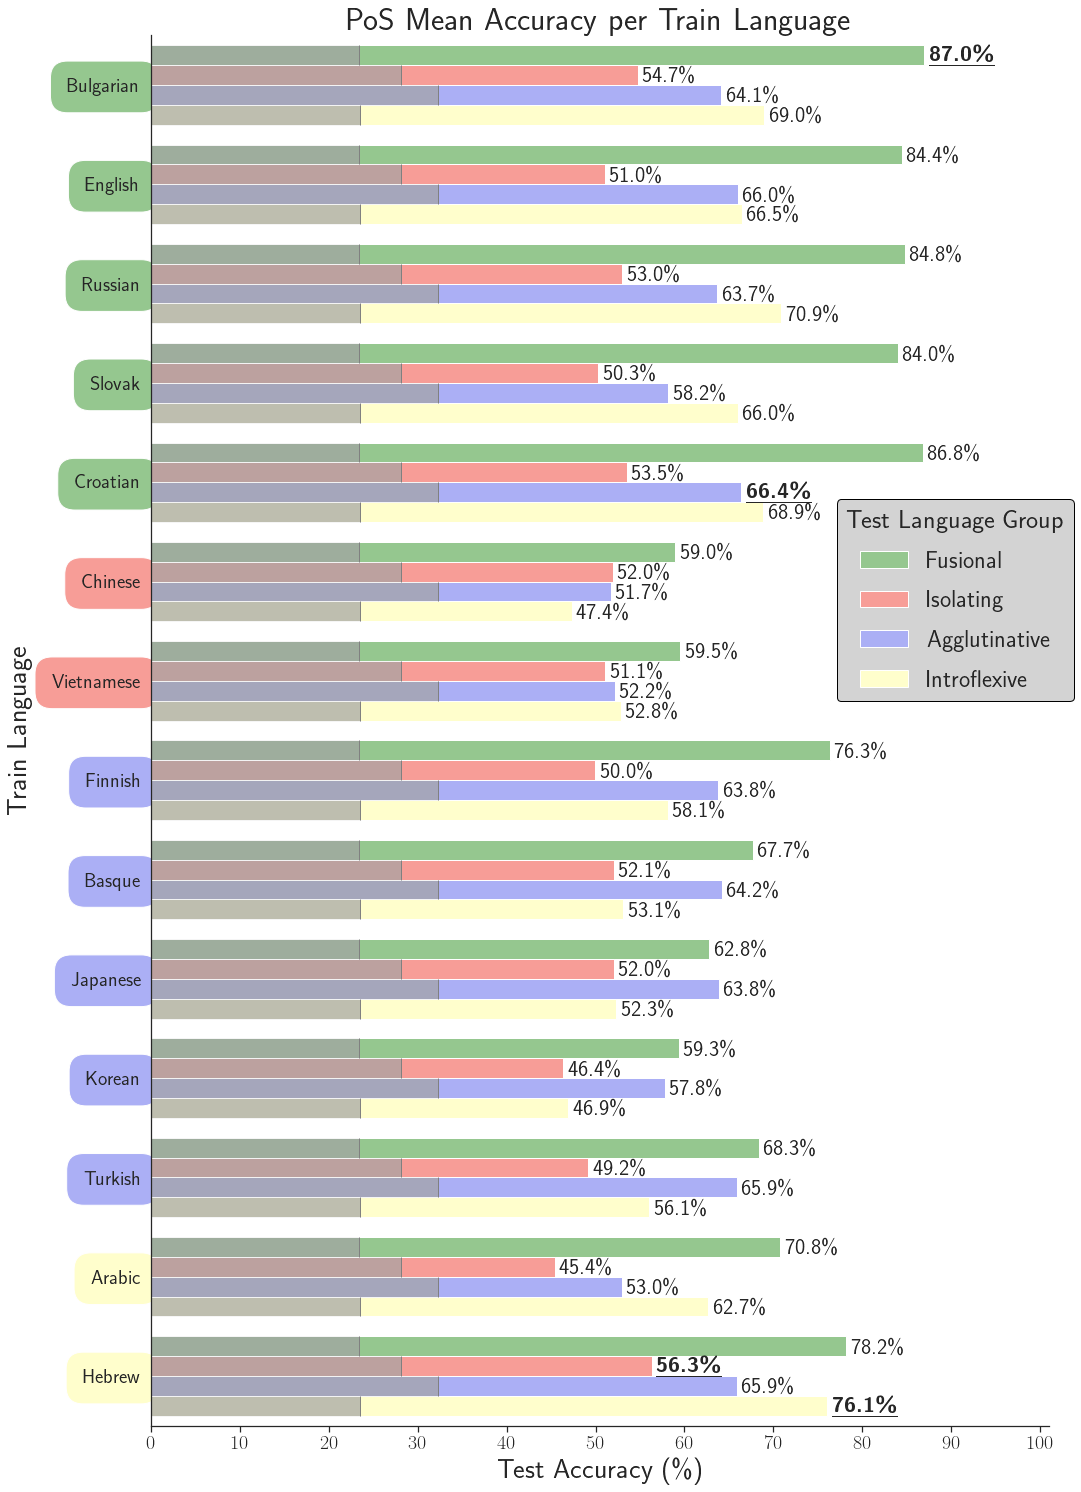

In [104]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [5, 2, 5, 2])]).sum()
extra_fontsize = 4

g = sns.catplot(
    data=df, kind="bar", x="Accuracy", y="Train Language", hue="Test Group",
    height=20, aspect=0.7, palette=colors, saturation=1, legend=False
)

langs = df["Train Language"].unique().tolist()
test_maxs = df[["Test Group", "Accuracy"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Accuracy"]["langvgroup"].loc[:3, "Baseline"].values * 100

for lang in langs:
    values = df.loc[(df["Train Language"] == lang), "Accuracy"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Language"] == lang]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.1f}\%".format(values[i]))
            extra_dy = 0
        else:
            p = "{:.1f}\%".format(values[i])
            extra_dy = 0.025
        g.ax.text(values[i] + 0.5, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        bline = (scale_y(langs.index(lang) + 0.1 + 0.2 * (i + 1), langs), 
                 scale_y(langs.index(lang) + 0.1 + 0.2 * i, langs))
        bbar = patches.Rectangle((0, langs.index(lang) + dy[i] + 0.1), baselines[i], -0.2, 
                              fill=True, color="#a3a3a3", alpha=0.7, ec=None)
        g.ax.add_patch(bbar)
        g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.75, 0.675), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 101))
plt.xticks(range(0, 101, 10))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Mean Accuracy per Train Language", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_lang_vs_group_results_accuracy.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

### A.2. Group vs Group Accuracy

In [2]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)

In [21]:
df = results["Accuracy"]["groupvgroup"].loc[:3, ["Test\Train", "Fusional", "Isolating", "Agglutinative", "Introflexive"]]
df = df.set_index("Test\Train").T.applymap(lambda x: x*100).reset_index()
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Train Group", 
                                                                                   "Test\Train": "Test Group",
                                                                                   "value": "Accuracy"})

In [22]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

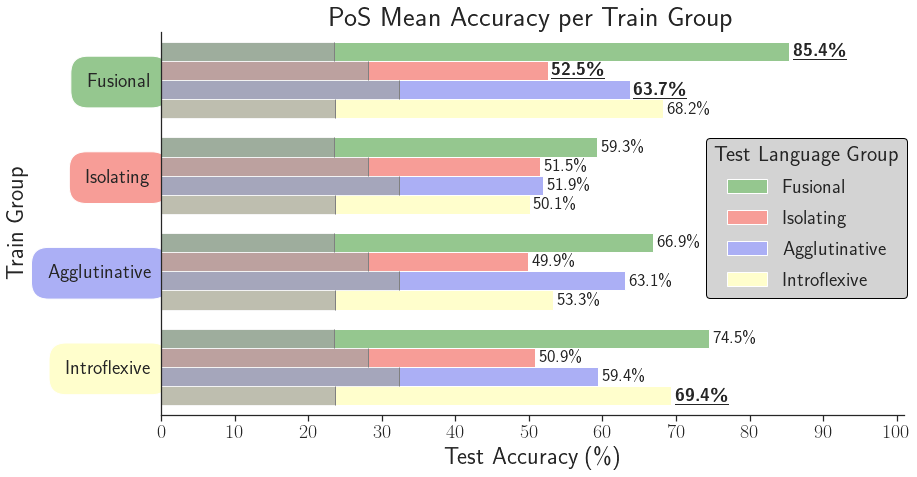

In [88]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
extra_fontsize = 0

g = sns.catplot(
    data=df, kind="bar", x="Accuracy", y="Train Group", hue="Test Group",
    height=6, aspect=2, palette=colors, saturation=1, legend=False
)

groups = df["Train Group"].unique().tolist()
test_maxs = df[["Test Group", "Accuracy"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Accuracy"]["langvgroup"].loc[:3, "Baseline"].values * 100

for group in groups:
    values = df.loc[(df["Train Group"] == group), "Accuracy"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Group"] == group]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.1f}\%".format(values[i]))
        else:
            p = "{:.1f}\%".format(values[i])
        g.ax.text(values[i] + 0.5, groups.index(group) + dy[i], p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        bline = (scale_y(groups.index(group) + 0.1 + 0.2 * (i + 1), groups), 
                 scale_y(groups.index(group) + 0.1 + 0.2 * i, groups))
        bbar = patches.Rectangle((0, groups.index(group) + dy[i] + 0.1), baselines[i], -0.2, 
                              fill=True, color="#a3a3a3", alpha=0.7, ec=None)
        g.ax.add_patch(bbar)
        g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.72, 0.75), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.xlim((0, 101))
plt.xticks(range(0, 101, 10))
plt.ylabel("Train Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Mean Accuracy per Train Group", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_group_vs_group_results_accuracy.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

### A.3. Dev-Test Performance Loss

In [183]:
code_dicts = utils.make_lang_code_dicts()
code_to_name = code_dicts["code_to_name"]
name_to_code = code_dicts["name_to_code"]

In [184]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [185]:
# Model parameters
max_length = 256
batch_size = 256
model_name = "bert-base-multilingual-cased"
tagset = ["O", "_", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", 
          "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]
num_labels = len(tagset)
label_map = {label: i for i, label in enumerate(tagset)}

# Model creation and loading weights
tokenizer = ABSATokenizer.from_pretrained(model_name)
config = transformers.BertConfig.from_pretrained(model_name, num_labels=num_labels)
model = TFBertForTokenClassification.from_pretrained(model_name,
                                                     config=config)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertForTokenClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [186]:
pos_eval = []
data_dir = "../data/ud/"
weights_filename = model_name + "_pos.hdf5"

for directory in tqdm(["ko", "tr", "ar"]):
    row_eval = {"Language": code_to_name[directory]}
    weights_path = "E:/TFM_CCIL/checkpoints/" + directory + "/"
    model.load_weights(weights_path + weights_filename)
    
    for dataset_name in ["dev", "test"]:
    # Load and preprocess
        path = os.path.join(data_dir, directory)
        test_examples, test_dataset = pos_utils.load_data(path, batch_size, tokenizer, tagset, max_length, dataset_name)

        # Predict
        preds = model.predict(test_dataset, steps=np.ceil(len(test_examples) / batch_size), verbose=1)

        # Postprocessing
        tokens, labels, filtered_preds, logits = pos_utils.filter_padding_tokens(test_examples, preds, label_map, tokenizer)
        subword_locations = pos_utils.find_subword_locations(tokens)
        new_tokens, new_labels, new_preds = pos_utils.reconstruct_subwords(subword_locations, tokens, labels, 
                                                                           filtered_preds, logits)

        # Metrics
        accuracy = (np.array(new_labels) == np.array(new_preds)).mean()
        row_eval[dataset_name] = accuracy
    pos_eval.append(row_eval)

4/4 [==============================] - 13s 3s/step



In [187]:
df = pd.DataFrame(pos_eval)
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Language",
                                                                                   "variable": "Dataset",
                                                                                   "value": "Accuracy"})
df["Accuracy"] = df["Accuracy"] * 100

In [188]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

In [189]:
df

,Language,Dataset,Accuracy
0,Korean,dev,96.277395
1,Turkish,dev,94.102813
2,Arabic,dev,97.193825
3,Korean,test,64.315002
4,Turkish,test,74.879619
5,Arabic,test,76.704737


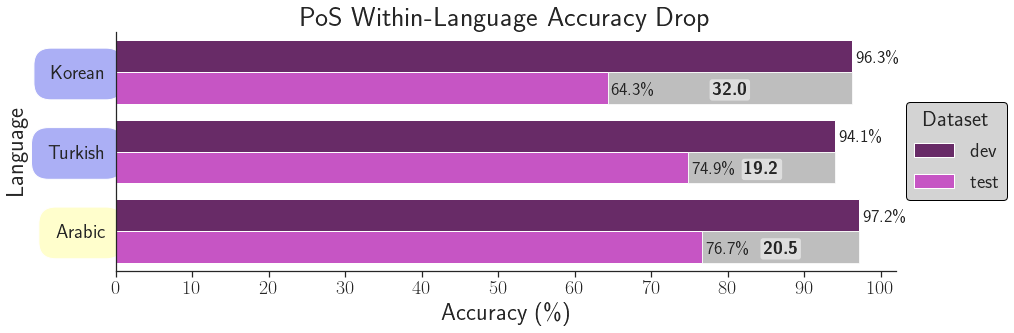

In [191]:
colors = {"dev": "#870c85", "test": "#ff1cfb"}
label_colors = ["#abaff5"] * 2 + ["#fffecc"]
extra_fontsize = 0

g = sns.catplot(
    data=df, kind="bar", x="Accuracy", y="Language", hue="Dataset",
    height=4, aspect=3, palette=colors, saturation=0.5, legend=False
)

langs = df["Language"].unique().tolist()

for lang in langs:
    values = df.loc[(df["Language"] == lang), "Accuracy"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(df.index[df["Language"] == lang]):
        p = "{:.1f}\%".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.5, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], langs.index(lang) + dy[i] + 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    g.ax.text(values.mean(), langs.index(lang) + dy[i] + extra_dy, r"\textbf{{{:.1f}}}".format(values[0] - values[1]), 
              verticalalignment="center", horizontalalignment="center", 
              fontsize=18 + extra_fontsize,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))

plt.legend(title="Dataset", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(1, 0.75), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.xticks(range(0, 101, 10))
plt.ylabel("Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Within-Language Accuracy Drop", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_accuracy_drop_devtest.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

### A.4. Below baseline?

In [121]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
df = results["Accuracy"]["langvlang"]

In [122]:
basedif = df.drop("Thai", axis=1).iloc[:15, 2:-1].apply(lambda x: x - df.loc[:14, "Baseline"]) * 100
basedif.insert(0, "Test\Train", df["Test\Train"])

In [132]:
cond.any(axis=0)

Bulgarian     False
English       False
Russian       False
Slovak         True
Croatian      False
Chinese        True
Vietnamese     True
Finnish       False
Basque        False
Japanese      False
Korean        False
Turkish       False
Arabic         True
Hebrew        False
dtype: bool

In [133]:
cond = basedif.iloc[:,1:] <= 5
basedif.loc[cond.any(axis=1)]

,Test\Train,Bulgarian,English,Russian,Slovak,Croatian,Chinese,Vietnamese,Finnish,Basque,Japanese,Korean,Turkish,Arabic,Hebrew
11,Korean,9.4549,10.6368,10.9865,3.73251,14.4175,4.93247,4.26918,16.8657,15.9491,5.6862,15.5813,16.3833,1.8753,13.2477


### A.5. Within- vs Cross-Language Performance

In [72]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
df = results["Accuracy"]["langvlang"].drop("Thai", axis=1)

In [73]:
df = pd.melt(df.iloc[:15,:-1], id_vars=df.iloc[:15,:-1].columns[:2], 
             value_vars=df.iloc[:15,:-1].columns[2:]).rename(columns={"Test\Train": "Test",
                                                                      "variable": "Train",
                                                                      "value": "Accuracy"})
df["Accuracy"] = df["Accuracy"].astype(float) * 100

In [74]:
df.head()

,Group,Test,Train,Accuracy
0,Fusional,Bulgarian,Bulgarian,98.772577
1,Fusional,English,Bulgarian,78.962572
2,Fusional,Russian,Bulgarian,91.021336
3,Fusional,Slovak,Bulgarian,87.810869
4,Fusional,Croatian,Bulgarian,90.156636


In [75]:
within_scores = df[df["Test"] == df["Train"]]

In [76]:
cross_scores = df.loc[~df.index.isin(within_scores.index)]

In [77]:
within_scores = within_scores.rename(columns={"Accuracy": "Accuracy-within"})
cross_scores = cross_scores.rename(columns={"Accuracy": "Accuracy-cross"})

In [78]:
within_vs_cross = pd.merge(within_scores.drop("Test", axis=1), cross_scores, on="Train", suffixes=("-train", "-test"))

In [119]:
within_vs_cross_avg = within_vs_cross[["Train", "Accuracy-within", "Accuracy-cross"]].groupby("Train", 
                                                                                              as_index=False, sort=False).mean()
within_vs_cross_avg.insert(0, "Group-train", within_scores["Group"].values)

In [92]:
pearsonr(x=within_vs_cross_avg["Accuracy-within"], y=within_vs_cross_avg["Accuracy-cross"])

(0.6422085495065253, 0.013270285989313629)

In [62]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

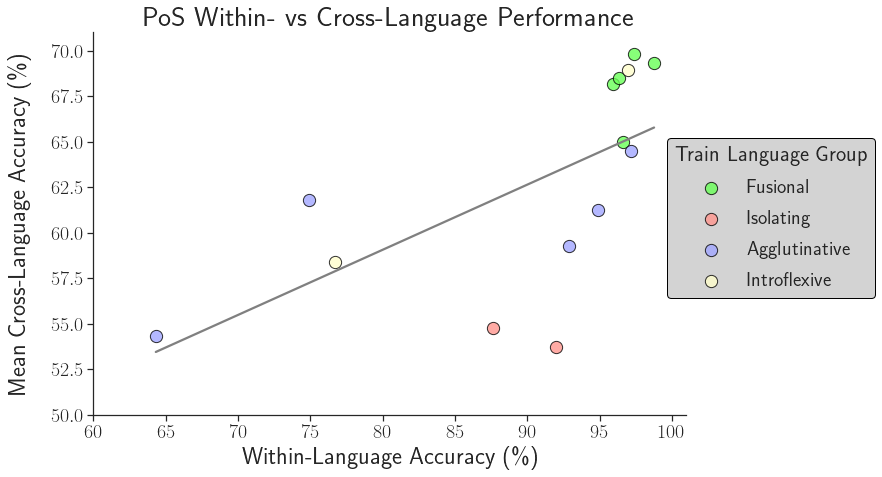

In [196]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="Accuracy-within", y="Accuracy-cross", data=within_vs_cross_avg, hue="Group-train", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="Accuracy-within", y="Accuracy-cross", data=within_vs_cross_avg, scatter=False, #ax=g.ax, 
            color="grey", ci=None)

plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.95, 0.75), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((50,71))
plt.xlim((60,101))
plt.ylabel("Mean Cross-Language Accuracy (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Within-Language Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Within- vs Cross-Language Performance", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_withinvs_cross_accuracy.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

It's actually more fair to average per group first

In [243]:
pearsonr(x=WvC_double_avg["Accuracy-within"], y=WvC_double_avg["Accuracy-cross"])

(0.6422696510432844, 0.013258706438344672)

In [204]:
WvC_double_avg = within_vs_cross.groupby(by=["Train", "Group-test"], sort=False, 
                                         as_index=False).mean().groupby(by="Train", sort=False, as_index=False).mean()
WvC_double_avg.insert(0, "Group-train", within_scores["Group"].values)

In [206]:
WvC_double_avg

,Group-train,Train,Accuracy-within,Accuracy-cross
0,Fusional,Bulgarian,98.772577,68.707871
1,Fusional,English,95.924391,66.996335
2,Fusional,Russian,96.326910,68.110030
3,Fusional,Slovak,96.614983,64.623715
4,Fusional,Croatian,97.374279,68.896503
5,Isolating,Chinese,91.972916,52.499452
6,Isolating,Vietnamese,87.626492,53.915907
7,Agglutinative,Finnish,97.209067,62.056058
8,Agglutinative,Basque,94.892098,59.267750
9,Agglutinative,Japanese,92.855806,57.743486


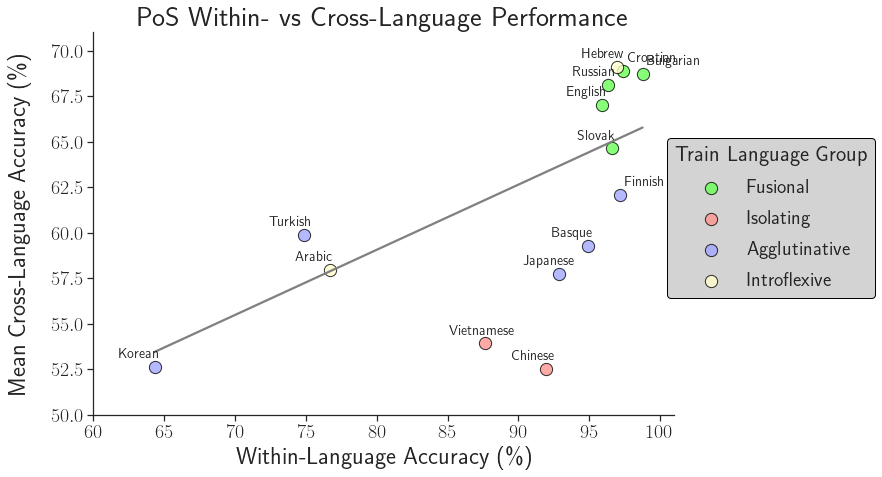

In [242]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="Accuracy-within", y="Accuracy-cross", data=WvC_double_avg, hue="Group-train", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="Accuracy-within", y="Accuracy-cross", data=within_vs_cross_avg, scatter=False, #ax=g.ax, 
            color="grey", ci=None)

for i, row in WvC_double_avg.iterrows():
    if row["Accuracy-within"] <= 97:
        dx = -2.5
    else:
        dx = 0.3
    plt.text(row["Accuracy-within"] + dx, row["Accuracy-cross"] + 0.5, row["Train"], fontsize=14)

plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.97, 0.75), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((50,71))
plt.xlim((60,101))
plt.ylabel("Mean Cross-Language Accuracy (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Within-Language Accuracy (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Within- vs Cross-Language Performance", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_within_vs_cross_accuracy.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

### A.6. Within-Language Performance Distribution

Not worth it, it's hard to see differences

In [283]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
df = results["Accuracy"]["langvlang"]

In [285]:
df = pd.DataFrame({"Train-Language": df.columns[2:-1], 
                   "Within-Accuracy": np.diagonal(df.iloc[:15, 2:-1].values)}).drop(7, axis=0).reset_index(drop=True)
idx = [True]*14 + [False]*2
idx.insert(7, False)
df.insert(0, "Group", results["Accuracy"]["langvlang"].loc[idx, "Group"].reset_index(drop=True))

In [286]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

In [287]:
df

,Group,Train-Language,Within-Accuracy
0,Fusional,Bulgarian,0.987726
1,Fusional,English,0.959244
2,Fusional,Russian,0.963269
3,Fusional,Slovak,0.96615
4,Fusional,Croatian,0.973743
5,Isolating,Chinese,0.919729
6,Isolating,Vietnamese,0.876265
7,Agglutinative,Finnish,0.972091
8,Agglutinative,Basque,0.948921
9,Agglutinative,Japanese,0.928558


(0.6, 1.0)

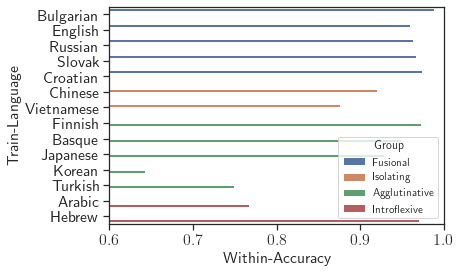

In [288]:
sns.barplot(x="Within-Accuracy", y="Train-Language", data=df, hue="Group")
plt.xlim((0.6,1))

### A.7. Transfer Loss

In [3]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
langvlang = results["Accuracy"]["langvlang"]
langvgroup = results["Accuracy"]["langvgroup"]

In [4]:
df = pd.DataFrame({"Train-Group": langvlang.iloc[:15, 0], "Train-Language": langvlang.columns[2:-1], 
                   "Within-Accuracy": np.diagonal(langvlang.iloc[:15, 2:-1].values)})

In [5]:
df_group = langvgroup.iloc[:4, [True] + [False] + [True]*15 + [False]]

In [6]:
df_group = pd.melt(df_group.rename(columns={"Test\Train": "Test-Group"}), id_vars="Test-Group", 
                   value_vars=df_group.columns[1:], 
                   var_name="Train-Language", value_name="Cross-Accuracy")

In [7]:
transfer = pd.merge(df, df_group, on="Train-Language")
transfer = transfer[transfer["Train-Language"] != "Thai"].reset_index(drop=True)
transfer["Cross-Accuracy"] = transfer["Cross-Accuracy"].astype(float) * 100
transfer["Within-Accuracy"] = transfer["Within-Accuracy"].astype(float) * 100

In [8]:
transfer["Transfer-Loss"] = transfer["Within-Accuracy"] - transfer["Cross-Accuracy"]

In [9]:
transfer.head()

,Train-Group,Train-Language,Within-Accuracy,Test-Group,Cross-Accuracy,Transfer-Loss
0,Fusional,Bulgarian,98.772577,Fusional,86.987853,11.784724
1,Fusional,Bulgarian,98.772577,Isolating,54.722207,44.050370
2,Fusional,Bulgarian,98.772577,Agglutinative,64.134517,34.638060
3,Fusional,Bulgarian,98.772577,Introflexive,68.986908,29.785669
4,Fusional,English,95.924391,Fusional,84.446718,11.477673


In [64]:
final = transfer[transfer["Test-Group"] != transfer["Train-Group"]].groupby(by=["Train-Group", "Train-Language"], 
                                                                    as_index=False, sort=False).mean()
final["Test-Group"] = "Others"

In [65]:
temp = transfer[transfer["Test-Group"] == transfer["Train-Group"]].copy()
temp.loc[:, "Test-Group"] = "Same"

In [72]:
final = pd.concat([final, temp], ignore_index=True)
final["sort"] = np.concatenate((np.arange(1, 28, 2), np.arange(0, 28, 2)))

In [76]:
final = final.sort_values("sort").reset_index(drop=True).drop("sort", axis=1)

In [78]:
final.head()

,Train-Group,Train-Language,Within-Accuracy,Cross-Accuracy,Transfer-Loss,Test-Group
0,Fusional,Bulgarian,98.772577,86.987853,11.784724,Same
1,Fusional,Bulgarian,98.772577,62.614544,36.158033,Others
2,Fusional,English,95.924391,84.446718,11.477673,Same
3,Fusional,English,95.924391,61.179540,34.744851,Others
4,Fusional,Russian,96.326910,84.801907,11.525003,Same


In [82]:
final["Relative-Transfer-Loss"] = final["Transfer-Loss"] / final["Within-Accuracy"]

In [79]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

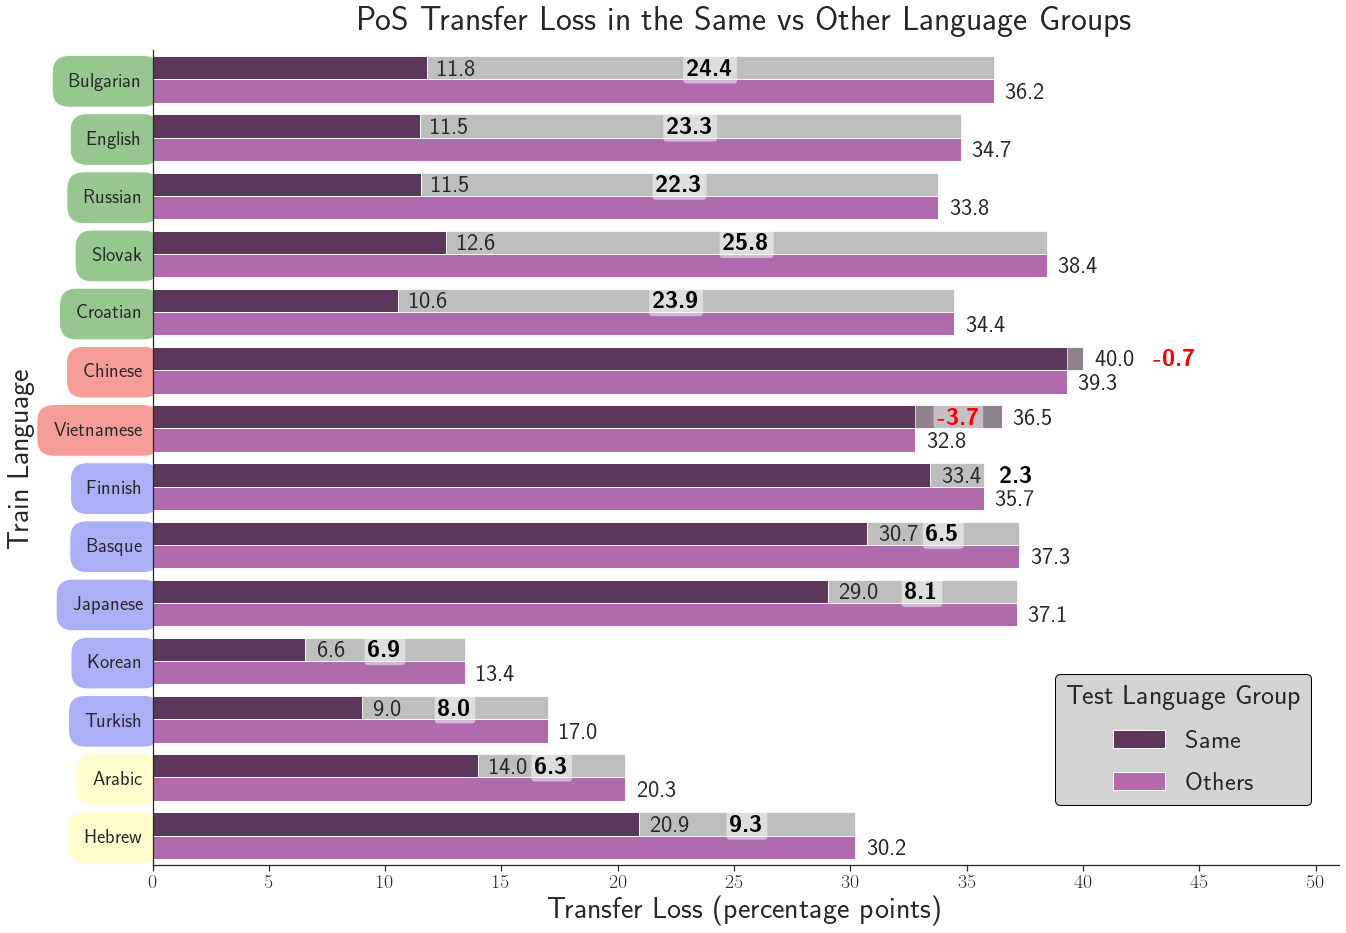

In [178]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [5, 2, 5, 2])]).sum()
extra_fontsize = 6

g = sns.catplot(
    data=final, kind="bar", x="Transfer-Loss", y="Train-Language", hue="Test-Group",
    height=12, aspect=1.5, palette=bar_colors, saturation=0.3, legend=False
)

langs = final["Train-Language"].unique().tolist()

for lang in langs:
    values = final.loc[(final["Train-Language"] == lang), "Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final.index[final["Train-Language"] == lang]):
        p = "{:.1f}".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.5, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], langs.index(lang) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if np.abs(diff) <= 3:
        align = "left"
        x = values[0] + 3
    if diff < 0:
        color = "red"
    g.ax.text(x, langs.index(lang) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.1f}}}".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.75, 0.25), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 51))
plt.xticks(range(0, 51, 5))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Transfer Loss (percentage points)", fontsize=24 +  extra_fontsize)
plt.title("PoS Transfer Loss in the Same vs Other Language Groups", fontsize=28 +  extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_transfer_loss_all.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [141]:
final_avg = final.groupby(by=["Train-Group", "Test-Group"], as_index=False, sort=False).mean()

In [142]:
final_avg

,Train-Group,Test-Group,Within-Accuracy,Cross-Accuracy,Transfer-Loss,Relative-Transfer-Loss
0,Fusional,Same,97.002628,85.405269,11.597359,0.119576
1,Fusional,Others,97.002628,61.487431,35.515197,0.366131
2,Isolating,Same,89.799704,51.536688,38.263016,0.425870
3,Isolating,Others,89.799704,53.764677,36.035027,0.400639
4,Agglutinative,Same,84.830319,63.086677,21.743642,0.240434
5,Agglutinative,Others,84.830319,56.715432,28.114887,0.319247
6,Introflexive,Same,86.842822,69.386161,17.456661,0.199095
7,Introflexive,Others,86.842822,61.590299,25.252523,0.288067


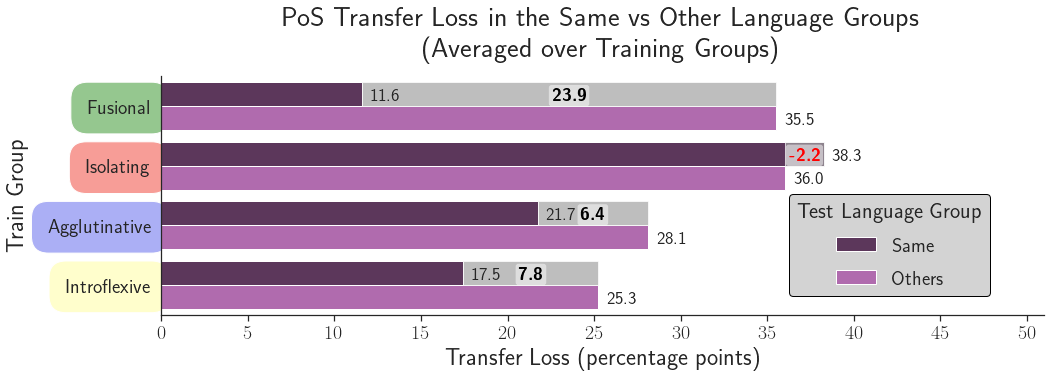

In [181]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
extra_fontsize = 0

g = sns.catplot(
    data=final_avg, kind="bar", x="Transfer-Loss", y="Train-Group", hue="Test-Group",
    height=4, aspect=3.5, palette=bar_colors, saturation=0.3, legend=False
)

groups = final_avg["Train-Group"].unique().tolist()

for group in groups:
    values = final_avg.loc[(final_avg["Train-Group"] == group), "Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final_avg.index[final_avg["Train-Group"] == group]):
        p = "{:.1f}".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.5, groups.index(group) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], groups.index(group) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if diff < 0:
        color = "red"
    g.ax.text(x, groups.index(group) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.1f}}}".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 0.55), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 51))
plt.xticks(range(0, 51, 5))
plt.ylabel("Train Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Transfer Loss (percentage points)", fontsize=24 +  extra_fontsize)
plt.title("PoS Transfer Loss in the Same vs Other Language Groups \n (Averaged over Training Groups)", 
          fontsize=28 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_transfer_loss_groups.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

Relative transfer loss tells the same story

In [195]:
final_avg["Relative-Transfer-Loss"] = final_avg["Relative-Transfer-Loss"] * 100

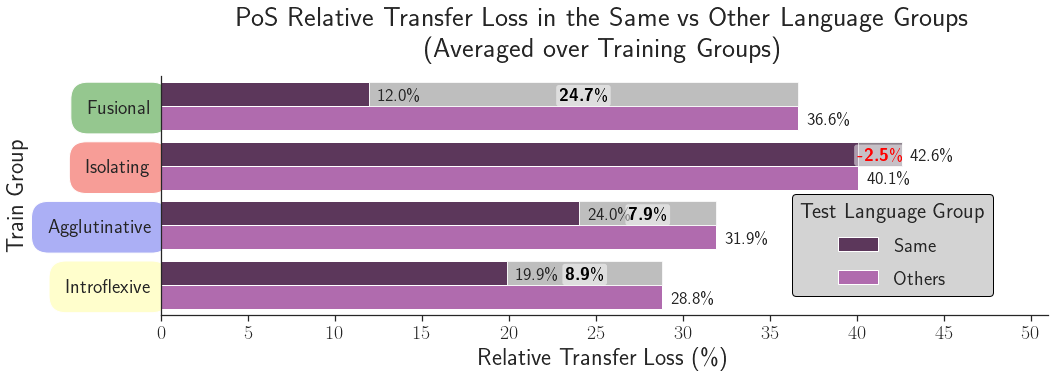

In [197]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
extra_fontsize = 0

g = sns.catplot(
    data=final_avg, kind="bar", x="Relative-Transfer-Loss", y="Train-Group", hue="Test-Group",
    height=4, aspect=3.5, palette=bar_colors, saturation=0.3, legend=False
)

groups = final_avg["Train-Group"].unique().tolist()

for group in groups:
    values = final_avg.loc[(final_avg["Train-Group"] == group), "Relative-Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final_avg.index[final_avg["Train-Group"] == group]):
        p = "{:.1f}\%".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.5, groups.index(group) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], groups.index(group) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if diff < 0:
        color = "red"
    g.ax.text(x, groups.index(group) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.1f}}}\%".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 0.55), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 51))
plt.xticks(range(0, 51, 5))
plt.ylabel("Train Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Relative Transfer Loss (\%)", fontsize=24 +  extra_fontsize)
plt.title("PoS Relative Transfer Loss in the Same vs Other Language Groups \n (Averaged over Training Groups)", 
          fontsize=28 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_relative_transfer_loss_groups.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()